In [1]:
import torch
import torch.nn as nn
import skorch
import numpy as np

from torch.autograd import Variable

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
from torch.utils.data import DataLoader, TensorDataset
from sine_data import train_dataset, valid_dataset

## Problems

```
>>> t = arange(100)
>>> y = sin(t/p * pi)
>>> lab.plot(t, y); lab.show()
```

is vastly different from

```
>>> t = linspace(0,100,100)
>>> y = sin(t/p * pi)
>>> lab.plot(t, y); lab.show()
```

and both are incorrect.


This is a consequence of the fact that the curve is not aligned to
integers (our time-steps) and if we sample at the time-step we will
get vastly different y-values due to the shift in phase. This can
be seen in the following figure where we compare the generated clock
wave function (blue) and the sampled points at the corresponding 
time-steps (orange):

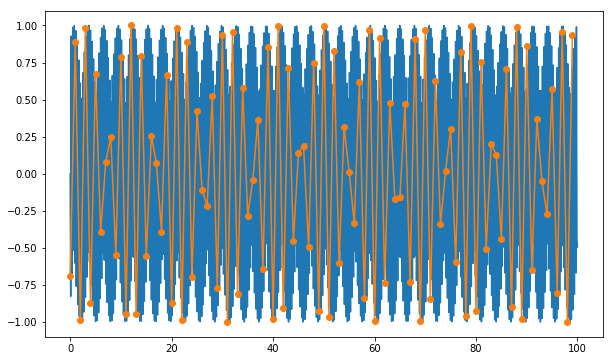

In [4]:
p = 0.006
#t = np.arange(100)
t = np.linspace(0, 100, 1000)
y = np.sin(t/p)
i = np.arange(0, 1000, 1000//100) + 4
plt.figure(figsize=(10, 6))
plt.plot(t, y)
#plt.plot(np.arange(100), np.zeros(100), 'o')
plt.plot(np.arange(100), y[i], 'o-')

By shifting the curve and aligning it to integers we gain a periodical
curve where the periodicity is a multiple of integer values. In the 
following figure we want a full period every `p=1` steps apart but the 
extrema aligned to integers:

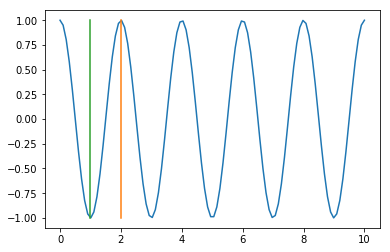

In [5]:
p = 1
t = np.linspace(0, 10, 100)
y = np.sin(t/p * np.pi + np.pi/2)
plt.plot(t, y)
plt.plot([2,2],[-1,1])
plt.plot([1,1],[-1,1])

We have to shift the sine wave to align with integers so that every time-step
is at the peak of the curve. It might work if we don't do this (eventually
the system will learn an optmial parametrization) but this is way better
to analyse.

Show that `np.pi/2` is the value to shift the curve to so that `p=0.5`
is an always-on neuron, `p=1` is on every second step, `p=2` every third and so on:

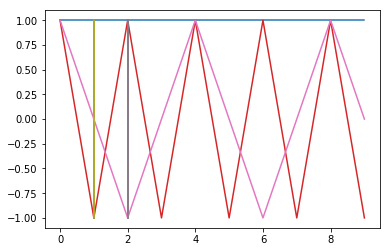

In [6]:
for p in [0.5,1,2]:
    #t = np.linspace(0, 10, 100)
    t = np.arange(10)
    y = np.sin(t/p * np.pi + np.pi/2)
    plt.plot(t, y)
    plt.plot([2,2],[-1,1])
    plt.plot([1,1],[-1,1])

There is still an open question about how to handle fractional periods, i.e. the period
values that can not be distributed evenly onto natural numbers. The period `p=27/20=1.35` is one
such case (if every "step" is 1.35 units apart then only every 20th step will be 
an even number):

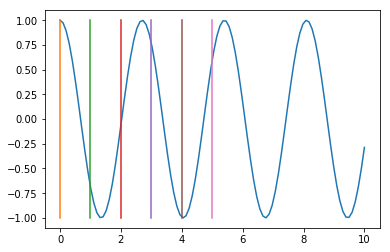

In [7]:
for p in [1.35]:
    t = np.linspace(0, 10, 100)
    y = np.sin(t/p*np.pi + np.pi/2)#/p * np.pi - np.pi/6*p)
    plt.plot(t, y)
    for i in range(6):
        plt.plot([i,i],[-1,1])

### Problem 3: half activations with longer periods

Consider the case where we have a longer period, say `p=3`. We will
inevitably have the case that the down/up slope of the function 
crosses with a integer. In the example case `x=1` results in `y=0.5`.
Ideally we would have a hard edge here, i.e. for `x=0` and `x=3` the
y-value is 1 but for all other cases it is 0. We cannot do that since
we need to be continuous for backpropagation to work:

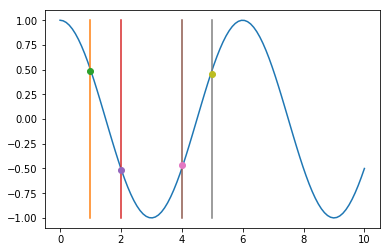

In [8]:
for p in [3]:
    t = np.linspace(0, 10, 100)
    y = np.sin(t/p*np.pi + np.pi/2)#/p * np.pi - np.pi/6*p)
    plt.plot(t, y)
    for i in [1,2,4,5]:
        plt.plot([i,i],[-1,1])
        plt.plot([i], y[np.where(abs(t - i) < 0.06)[0][0]], 'o')

We can try to be clever and use a rectifier on a the y-shifted sine curve so that
activation is limited to the periodic integer and neighboring time-steps are zero.
Formally this is done by assuming that at `t=0` we always have an activation and
further we don't expect an activation at `t=1` in *every* case. This means we
can shift the curve on the y-axis by the difference of the curve at `t=0` and
`t=1`:

    rfact = 1 - (np.sin(0/p*np.pi + np.pi/2) - np.sin(1/p*np.pi + np.pi/2))
    y = np.sin(t/p*np.pi + np.pi/2) - rfact

This can be plugged in a rectifier, reducing negative values to 0.
The end result is a low activation at our period and no activation everywhere
else. To amplify the activation at the correct period we simply multiply the
difference of our correction factor:

    y = relu(y) * (1/(1 - rfact))

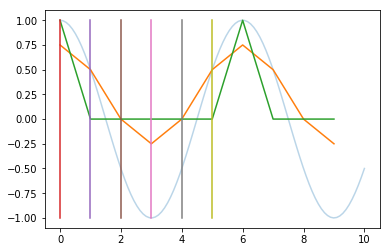

In [125]:
def nprelu(y):
    recty = y.copy()
    recty[y < 0] = 0
    return recty

for p in [3]:
    t = np.arange(10)
    tl = np.linspace(0, 10, 100)
    plt.plot(tl, np.sin(tl/p*np.pi + np.pi/2), alpha=0.3)
    rfact = 1 - (np.sin(0/p*np.pi + np.pi/2) - np.sin(1/p*np.pi + np.pi/2))
    y = np.sin(t/p*np.pi + np.pi/2) - rfact
    plt.plot(t, (y+1)/2)
    plt.plot(t, nprelu(y) * (1/(1-rfact)))
    for i in range(6):
        plt.plot([i,i],[-1,1])

- A potential drawback of the aforementioned method is that `p=0.5` (activation at every time-step)
is not possible anymore since we disallow an activation at `t=0` and `t=1` at the same time.
- The function in itself is also not smooth anymore which makes combination at higher levels 
difficult.
- Using non-integer (or well divisible) periods (e.g. `p=1.35`) will still give stray activations

Since it is not clear whether having hard edges at the activations is beneficial or not it is
not worth further pursuing this problem at this time.

### Problem: Continuity of clock periods

Is increasing the clock periodicity breaking the continuity of the discretized clock function?
In other words: if the clock periodicity is increased in small steps, do I get the expected (partial)
improvement in frequency or does it result in garbage activations? This is important to know since
backpropagation changes values iteratively in small steps.

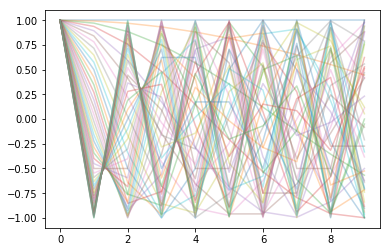

In [105]:
ps = []
for p in np.arange(0.5, 1.0, 0.01):
    #t = np.linspace(0, 10, 100)
    t = np.arange(10)
    y = np.sin(t/p * np.pi + np.pi/2)
    plt.plot(t, y, alpha=0.3)
    ps.append(p)
#plt.legend(ps)

In [85]:
class Clocking(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh', update_state_with_output=False):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.update_state_with_output = update_state_with_output
        
        self.i2h = nn.Linear(input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        #self.period = nn.Parameter(torch.randn(hidden_dim) + 1)
        self.period = nn.Parameter(torch.ones(hidden_dim))# - 0.5)
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
    def forward(self, x, clock=None, h=None): # x is (b, t, u) 
        if h is None:
            h = torch.zeros(self.hidden_dim)
            h = skorch.utils.to_var(h, x.is_cuda)
            
        ys = []
        cs = []
        for ti in range(x.size(1)):
            clock_gate = (torch.sin(ti/self.period * np.pi + np.pi/2) + 1) / 2
            # enable stacking of clocking functions
            if clock is not None:
                clock_gate = (clock_gate + clock[ti]) / 2

            h_new = self.i2h(x[:, ti]) + self.h2h(h)
            h = clock_gate * h_new + (1 - clock_gate) * h
            y = self.act(h)
            if self.update_state_with_output:
                h = y
            ys.append(y)
            cs.append(clock_gate)
        return torch.stack(ys, dim=1), h, torch.stack(cs, dim=0)

In [86]:
import visdom
vis = visdom.Visdom()

In [87]:
X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=400)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [88]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [89]:
class ReconModel(nn.Module):
    def __init__(self, num_hidden=64, act='tanh', num_layers=1, update_state_with_output=True, inherit_clocks=True):
        super().__init__()
        
        self.rnn = []
        self.num_layers = num_layers
        self.inherit_clocks = inherit_clocks
        
        for i in range(num_layers):
            input_dim = 1 if i == 0 else num_hidden
            self.rnn.append(Clocking(input_dim, num_hidden, act=act, update_state_with_output=update_state_with_output))
            self.add_module('rnn'+str(i), self.rnn[-1])
        
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        li = x
        ci = None
        for i in range(self.num_layers):
            if not self.inherit_clocks:
                ci = None
            li, hi, ci = self.rnn[i](li, clock=ci)
            vis.heatmap(skorch.utils.to_numpy(li[0]), opts={'title': 'act rnn'+str(i)}, win="act rnn"+str(i))
            vis.heatmap(skorch.utils.to_numpy(self.rnn[i].period).reshape(1, -1), opts={'title': 'periods rnn'+str(i)}, win="periods rnn"+str(i))
            vis.heatmap(skorch.utils.to_numpy(ci), opts={'title': 'clock rnn'+str(i)}, win="clock rnn"+str(i))
        l1 = self.clf(time_flatten(li))
        return time_unflatten(l1, x.size())

In [137]:
class Trainer(skorch.NeuralNet):
    def __init__(
        self, 
        criterion=nn.MSELoss,
        period_lr=0.02,
        *args, 
        **kwargs
    ):
        self.period_lr = period_lr
        super().__init__(*args, criterion=criterion, **kwargs)
        
    def initialize_optimizer(self):
        kwargs = self._get_params_for('optimizer')
        if 'lr' not in kwargs:
            kwargs['lr'] = self.lr
        
        normal_params, period_params = [], []
        for name, param in self.module_.named_parameters():
            if '.period' in name:
                period_params.append(param)
            else:
                normal_params.append(param)
                
        self.optimizer_ = self.optimizer([
                {'params': normal_params},
                {'params': period_params, 'lr': self.period_lr, 'momentum': 0},
            ],
            **kwargs)
        
    def get_loss(self, y_pred, y_true, X=None, training=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, training=training)

In [138]:
class GradFoo(skorch.callbacks.Callback):
    """ Attempt to make period gradients a multiple of 0.5 """
    def initialize(self):
        self.init = False
        
    def on_grad_computed(self, net, parameters):
        beta = 0.5
        pg = net.optimizer_.param_groups[1]

        if not self.init:
            pg['lr'] = 1
            pg['momentum'] = 0
            pg['nesterov'] = False
            pg['grad_buf'] = []
            pg['step'] = 0
            for param in pg['params']:
                pg['grad_buf'].append(torch.zeros_like(param.data))
            self.init = True
            
        pg['step'] += 1
        for i, param in enumerate(pg['params']):
            pg['grad_buf'][i] = pg['grad_buf'][i] * beta + param.grad.data * (1 - beta)
            ot = pg['grad_buf'][i].abs() >= 0.000001
            param.grad[ot] = param.grad[ot].data.sign_().mul_(0.5)
            param.grad[~ot] = 0
            pg['grad_buf'][i][ot] = 0

In [175]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef = Trainer(module=ReconModel,
             optimizer=torch.optim.Adam,
             #optimizer__momentum=0.85,
             #optimizer__nesterov=True,
             lr=0.02,
             period_lr=0.02,
             max_epochs=40,
             train_split=my_train_split,
             batch_size=1,
             
             module__num_hidden=16,
             module__act='relu',
             module__num_layers=2,
             module__inherit_clocks=True,
             module__update_state_with_output=False,
             use_cuda=False,
             
             #callbacks=[GradFoo()]
            )

In [176]:
%pdb on
ef.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.8361        0.4451  2.0553
      2        0.3520        0.1522  2.0688
      3        0.1282        0.1826  2.1522
      4        0.1300        0.0385  2.0978
      5        0.0444        0.0349  2.2676
      6        0.0357        0.0182  2.2162
      7        0.0197        0.0193  2.1111
      8        0.0222        0.0074  1.9396
      9        0.0147        0.0048  2.0068
     10        0.0116        0.0061  2.0241
     11        0.0080        0.0029  2.0386
     12        0.0059        0.0034  1.9568
     13        0.0054        0.0021  1.9995
     14        0.0040        0.0015  2.0692
     15        0.0033        0.0013  2.2164
     16        0.0028        0.0012  2.0411
     17        0.0024        0.0009  2.0081
     18        0.0022        0.0009  2.0211
     19        0.0020        0.0008  2.0469
     20        0.0019        0.0007

<class '__main__.Trainer'>[initialized](
  module_=ReconModel(
    (rnn0): Clocking(
      (i2h): Linear(in_features=1, out_features=16)
      (h2h): Linear(in_features=16, out_features=16)
      (act): ReLU()
    )
    (rnn1): Clocking(
      (i2h): Linear(in_features=16, out_features=16)
      (h2h): Linear(in_features=16, out_features=16)
      (act): ReLU()
    )
    (clf): Linear(in_features=16, out_features=1)
  ),
)

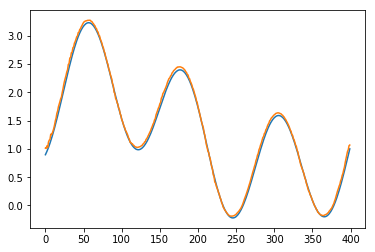

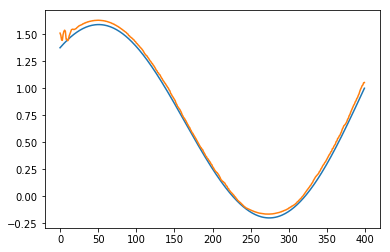

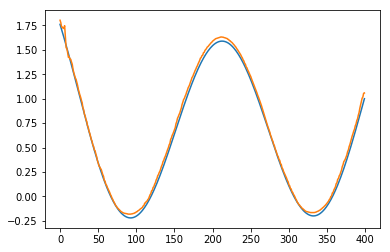

In [177]:
data = X_valid
pred = ef.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])